In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import copy
import time

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#global veriable 
Uniform_low_bound=0
Uniform_up_bound=1
Agent_number_n=5

number_of_groups=2

Normal_loc=0.5
Normal_scale=0.2
Normal_loc1=0.3
Normal_loc2=0.7
Normal_scale1=0.1
Normal_scale2=0.1
Distribution_number=10000
target = "min_sum"
#target = "min_max"

In [3]:
popSize = 100
eliteSize = 10
mutationRate = 0.1
generations = 50

global NeighborhoodRate
NeighborhoodRate = 0.05

In [4]:
class Foo(object):

    def __init__(self, test_item, test_change_item, deadline):
        self.test_item = test_item
        self.test_change_item = test_change_item
        self.deadline = deadline

    def __lt__(self, other):
        return self.test_change_item < other.test_change_item

[0 0 1 0 1]


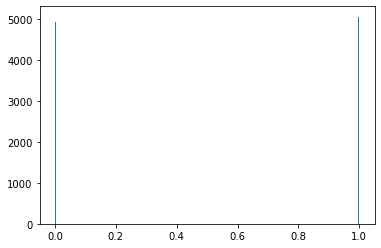

1000
9000


In [5]:

seed = 7
np.random.seed(seed)
#exec(open('distribution/uniform.py').read())
#exec(open('distribution/beta.py').read())
exec(open('../../distribution/twopeak.py').read())
for i in range(len(value_list)):
    for j in range(len(value_list[0])):
        if(value_list[i][j]<=0):
            value_list[i][j]=0
        if(value_list[i][j]>=1):
            value_list[i][j]=1
            
value_list1=np.array(value_list)
for i in range(min(Agent_number_n,1)):
    pa=value_list1[:,i]
    plt.hist(pa,bins=200)
    plt.show()


X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
#run_cs()

In [6]:
#Cost Sharing
def run_cs_prue():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item+1e-9>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs_prue()

max_delay 0.968
sum_delay 2.4945555555555554


In [7]:
def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result

def cost_sharing_with_deadline_free(n,_i,numbers_of_people_will_pay,started_k):
    
    for k in range(started_k,0,-1):
        if(n-_i<=k):
            x=k-1
        else:
            x=k
        #print(n,_i,x,numbers_of_people_will_pay[x],k)
        if(numbers_of_people_will_pay[x]>=k):
            return True,k
    return False,0

#Cost Sharing
def run_cs(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_train)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_train[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number
    #print("deadline:",deadline," sum_delay: ",sum_delay/test_number);
    


1.Create a fitness function

In [8]:
class Deadline_list:
    def __init__(self, deadline):
        self.deadline = deadline
        self.delay = 0
        self.fitness = 0.0
    
    def Delay(self):
        if self.fitness == 0:
            self.delay = run_cs(self.deadline)
            self.fitness = self.delay
            
            #print(self.deadline,self.fitness)
        return self.delay,self.deadline


## Create our initial population

Initial generator

Create first "population" (list of routes)

## Create the genetic algorithm

Rank individuals

Create a selection function that will be used to make the list of parent routes

Create mating pool

Create a crossover function for two parents to create one child

Create function to run crossover over full mating pool

Create function to mutate a single route

Create function to run mutation over entire population

Put all steps together to create the next generation

Final step: create the genetic algorithm

## Running the genetic algorithm

Create list of cities

Run the genetic algorithm

In [9]:
appendlist=[]
appendlist.append(0)
for i in range(Agent_number_n):
    appendlist.append(1.0/(i+1))
temp=1e9


for i1 in range(len(appendlist)):
    for i2 in range(len(appendlist)):
        for i3 in range(len(appendlist)):
            for i4 in range(len(appendlist)):
                for i5 in range(len(appendlist)):
                    x1= appendlist[i1]
                    x2= appendlist[i2]
                    x3= appendlist[i3]
                    x4= appendlist[i4]
                    x5= appendlist[i5]
                    result_temp=run_cs([x1,x2,x3,x4,x5])
                    if(temp>result_temp):
                        temp=result_temp
                        result=Deadline_list([x1,x2,x3,x4,x5])
print("training delay")
print(result.delay)
print("training deadline:")
for i in range(len (result.deadline)):
    print(result.deadline[i])

training delay
0
training deadline:
0
0
1.0
0
1.0


In [10]:
print(temp)
print("training delay")
print(result.delay)
print("training deadline:")
for i in range(len (result.deadline)):
    print(result.deadline[i])

1.76
training delay
0
training deadline:
0
0
1.0
0
1.0


In [11]:
print(run_cs(result.deadline))

#Cost Sharing
def run_cs_test(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
                

    return max_delay/test_number,sum_delay/test_number

    
print("test:",run_cs_test(result.deadline))

1.76
test: (0.7513333333333333, 1.769111111111111)


In [12]:
print("pure CS")
run_cs_prue()

pure CS
max_delay 0.968
sum_delay 2.4945555555555554


In [13]:
print("0.5 for test:",run_cs_test([0.5 for i in range(Agent_number_n)]))
print("0.5 for train:",run_cs([0.5 for i in range(Agent_number_n)]))
print("GA test:",run_cs_test(result.deadline))


0.5 for test: (0.5755555555555556, 2.0997777777777777)
0.5 for train: 2.169
GA test: (0.7513333333333333, 1.769111111111111)


In [14]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,501):
    x=float(i)/500
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_test(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])

max_delay: 0.5755555555555556 deadline: 0.5
sum_dealy: 2.0997777777777777 deadline: 0.5


In [15]:
print("target:",target)
print("sum_delay")
print("GA:",run_cs_test(result.deadline)[1],"one_deadline:",min(list_2))
print("{:.4%}".format(run_cs_test(result.deadline)[1]/min(list_2)))

target: min_sum
sum_delay
GA: 1.769111111111111 one_deadline: 2.0997777777777777
84.2523%


In [16]:
print("max_delay")
print(run_cs_test(result.deadline)[0],"one_deadline:",min(list_1))
print("{:.4%}".format(run_cs_test(result.deadline)[0]/min(list_1)))

max_delay
0.7513333333333333 one_deadline: 0.5755555555555556
130.5405%


In [17]:
def cost_sharing_with_deadline_old(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result



#Cost Sharing
def run_cs_old(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])
            
        
        temp_max_delay_list,temp_sum_delay,judge1 = cost_sharing_with_deadline_old(test_change,
                        copy.deepcopy(deadline_list),1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change);
            test_i = np.delete(test_i, j)
            
            deadline_i = copy.deepcopy(deadline_list);
            deadline_i = np.delete(deadline_i, j)
            
            temp_max_delay_i_list,temp_sum_delay_i,judge_i = cost_sharing_with_deadline_old(test_i,
                        deadline_i,1.0)
            
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[j])
                temp_max_delay_list[j] += (1.0-deadline_list[j])
                
            
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
    print("deadline: ",deadline_list)
    print("sum_delay: ",sum_delay/test_number)
    print("max_delay: ",max_delay/test_number)
    print()
    return max_delay/test_number,sum_delay/test_number
    
print(run_cs_old(result.deadline))


deadline:  [0, 0, 0, 1.0, 1.0]
sum_delay:  1.769111111111111
max_delay:  0.7513333333333333

(0.7513333333333333, 1.769111111111111)
